# import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

## Dataset load

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train','test'],
    shuffle_files=True,
    with_info=True
)

# Baseline Model
- ResNet50 + GAP + Dense Layer

In [4]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top = False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
pred = keras.layers.Dense(num_classes, activation='softmax')(x)
resnet50 = keras.Model(inputs=base_model.input, outputs=pred)

In [5]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Training Model

In [6]:
def normalized_and_resize_img(input):
    img = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(img, tf.float32) / 255.
    
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalized_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
batch_size = 16
epochs = 15

In [8]:
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=batch_size)
ds_test_norm = apply_normalize_on_dataset(ds_test, batch_size=batch_size)

In [9]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [10]:
import os
import pickle

resnet_history_path = '/home/aiffel0049/aiffel/Going_Deeper/5.class_activation_map/checkpoint/resnet_history.pkl'
resnet_model_path = '/home/aiffel0049/aiffel/Going_Deeper/5.class_activation_map/checkpoint/resnet_model.h5'

if not os.path.exists(resnet_history_path) or not os.path.exists(resnet_model_path):
    history_resnet_model = resnet50.fit(
        ds_train_norm,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test_norm,
        verbose=1,
        use_multiprocessing=True,
    )
    history_resnet_model = history_resnet_model.history
    pickle.dump(history_resnet_model, open(resnet_history_path, 'wb'))
    resnet50.save(resnet_model_path)

else:
    history_resnet_model = pickle.load(open(resnet_history_path, 'rb'))
    resnet50 = tf.keras.models.load_model(resnet_model_path)

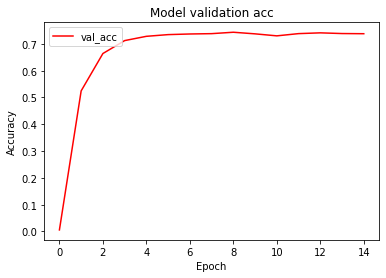

In [39]:
plt.plot(history_resnet_model['val_accuracy'], 'r')
plt.title('Model validation acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val_acc'], loc='upper left')
plt.show()

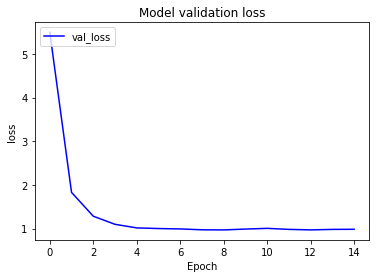

In [40]:
plt.plot(history_resnet_model['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['val_loss'], loc='upper left')
plt.show()

# CAM vs Grad-CAM 구현

## 테스트용 이미지 하나 가져오기

In [11]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    
    return sample_data[0]

(194, 259, 3)
130


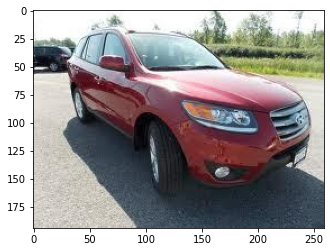

In [12]:
item = get_one(ds_test)
print(item['image'].shape)
print(item['label'])
plt.imshow(item['image'])

## CAM 생성

In [13]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalized_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, pred = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image)  # activation score normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))  # 원래 이미지의 크기로 resize
    # TODO: generate cam image
    return cam_image

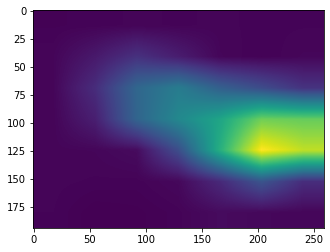

In [14]:
cam_image = generate_cam(resnet50, item)
plt.imshow(cam_image)

In [15]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    # TODO: blend image
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

<class 'numpy.ndarray'>


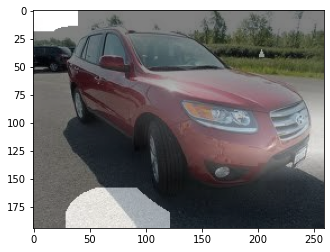

In [16]:
# visualize_cam_on_image() 함수 사용

print(type(item['image']))

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(cam_blended_image)

## Grad-CAM 구현

In [17]:
def generate_grad_cam(model, activation_layer, item):
    # TODO: generate grad_cam_image
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalized_and_resize_img(item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # gradient를 얻기 위한 tape
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻음
        output = conv_output[0]  # 원하는 layer의 output을 얻음
        grad_val = tape.gradient(loss, conv_output)[0]  # 예측값에 따른 layer의 gradient를 얻음
    
    weights = np.mean(grad_val, axis=(0, 1))  # gradient의 GAP으로 class별 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

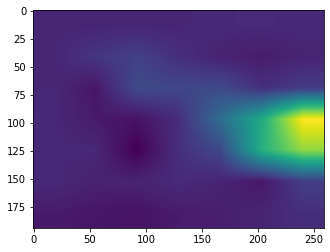

In [18]:
grad_cam_image = generate_grad_cam(resnet50, 'conv5_block2_out', item)
plt.imshow(grad_cam_image)

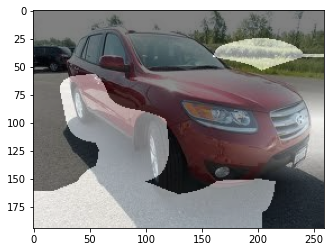

In [19]:
# visualize_cam_on_image() 함수 사용

type(item['image'])

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)

# 바운딩 박스 구하기

In [20]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indices = cam_image <= score_thresh
    cam_image[low_indices] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

## CAM bounding box

In [21]:
image = copy.deepcopy(item['image'])
cam_rect = get_bbox(cam_image)
cam_rect

array([[255, 184],
       [ 20, 146],
       [ 42,  15],
       [276,  54]])

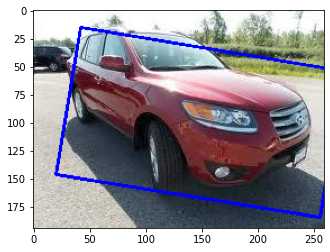

In [22]:
cam_image = cv2.drawContours(image,[cam_rect],0,(0,0,255),2)
plt.imshow(cam_image)

## Grad-CAM bounding box

In [23]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[257, 172],
       [ 34, 128],
       [ 55,  21],
       [278,  65]])

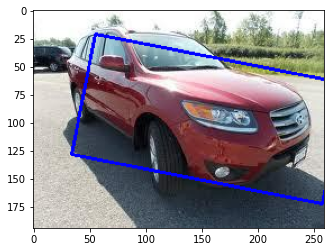

In [24]:
grad_image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(grad_image)

# IoU 구하기

In [25]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min()/float(image.shape[0]), # bbox y min
        rect[:, 0].min()/float(image.shape[1]), # bbox x min
        rect[:, 1].max()/float(image.shape[0]), # bbox y max
        rect[:, 0].max()/float(image.shape[1])  # bbox x max
    ]
    return bbox

In [ ]:
def get_iou(gt_bbox, pred_bbox):
    # TODO: get iou between two bbox
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    gtArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    predArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(gtArea + predArea - interArea)
    return iou

## CAM IoU

In [33]:
cam_bbox = rect_to_minmax(cam_rect, item['image'])
cam_bbox

[0.07731958762886598,
 0.07722007722007722,
 0.9484536082474226,
 1.0656370656370657]

In [34]:
get_iou(item['bbox'], cam_bbox)

0.7748936338890232

## Grad-CAM IoU

In [35]:
grad_bbox = rect_to_minmax(grad_rect, item['image'])
grad_bbox

[0.10824742268041238,
 0.13127413127413126,
 0.8865979381443299,
 1.0733590733590734]

In [36]:
get_iou(item['bbox'], grad_bbox)

0.8431336484509252

# 결론
1. ResNet50 + GAP + DenseLayer가 정상적으로 수렴함
2. class_activation map을 정상적으로 얻어냄
3. CAM과 Grad-CAM의 원본이미지와 바운딩박스를 합성하고, IoU를 계산한 결과
    - Grad-CAM이 CAM보다 높은 localization 성능을 보임